# Verification : comparing forecasts and real data

Data used : Open-Meteo's forecasts for 2023-11-15 to 2023-11-22 obtained on 2023-11-15, Open-Meteo's historic data for 2023-11-15 to 2023-11-22 and meteoblue's historic data averages.

Open-Meteo's data is at location ["latitude": 48.81452162820077, "longitude": 2.3948078406657114], specific point in Ivry-sur-Seine corresponding to our school, ESME. <br>
Meteoblue's data is an average for Ivry-sur-Seine, at location [48.82, 2.38].

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../src/data/')
from make_dataset import create_session

Meteoblue's data :

![Meteoblue](../data/historic_2023-11.png "Meteoblue")

['date', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'wind_direction_10m', 'apparent_temperature', 'cloud_cover', 'precipitation', 'weather_code', 'is_day', 'description']


date                    datetime64[ns]
temperature_2m                 float64
relative_humidity_2m           float64
wind_speed_10m                 float64
wind_direction_10m             float64
apparent_temperature           float64
cloud_cover                    float64
precipitation                  float64
weather_code                   float64
is_day                         float64
description                     object
dtype: object

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

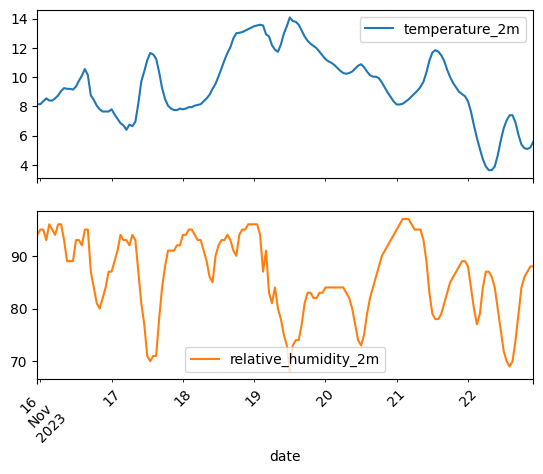

In [35]:
forecast_df = pd.read_csv("../data/forecast_2023-11-15.csv", index_col=0)
forecast_df["date"] = pd.to_datetime(forecast_df["date"])
print(list(forecast_df.columns))
display(forecast_df.dtypes)
forecast_df.sort_values("date").plot(x="date", y=["temperature_2m", "relative_humidity_2m"], kind="line", rot=45, subplots=True)

Getting historic data :

['date', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'wind_direction_10m', 'apparent_temperature', 'cloud_cover', 'precipitation', 'weather_code', 'is_day']


date                    datetime64[ns]
temperature_2m                 float32
relative_humidity_2m           float32
wind_speed_10m                 float32
wind_direction_10m             float32
apparent_temperature           float32
cloud_cover                    float32
precipitation                  float32
weather_code                   float32
is_day                         float32
dtype: object

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

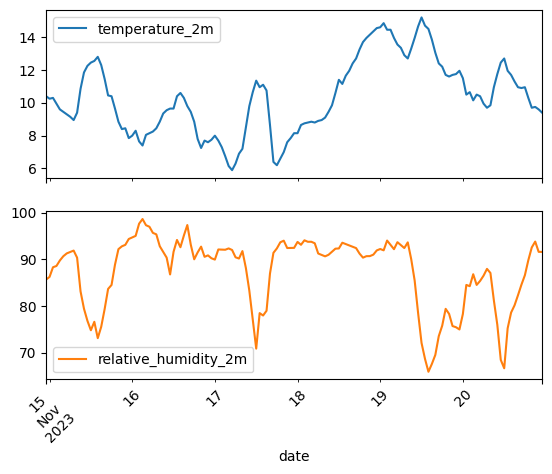

In [36]:
openmeteo = create_session()
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 48.81452162820077,
	"longitude": 2.3948078406657114,
	"start_date": "2023-11-15",
	"end_date": "2023-11-22",
	"hourly": ["temperature_2m", 
            "relative_humidity_2m", 
            "wind_speed_10m",
            "wind_direction_10m",
            "apparent_temperature",
            "cloud_cover",
            "precipitation", 
            "weather_code",
            "is_day"
            ],
    "timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)
response = responses[0]
hourly = response.Hourly()
hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit = "s"),
        end=pd.to_datetime(hourly.TimeEnd(), unit = "s"),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
        )
    }
for i in range(hourly.VariablesLength()):  # Iterating through all the variables in params["hourly"]
    hourly_data[params["hourly"][i]] = hourly.Variables(i).ValuesAsNumpy()

historic_df = pd.DataFrame(data=hourly_data).sort_values("date").dropna()
print(list(historic_df.columns))
display(historic_df.dtypes)
historic_df.sort_values("date").plot(x="date", y=["temperature_2m", "relative_humidity_2m"], kind="line", rot=45, subplots=True)

## Comparing 

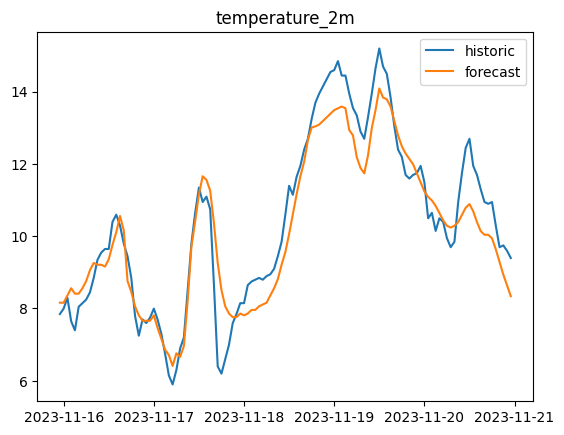

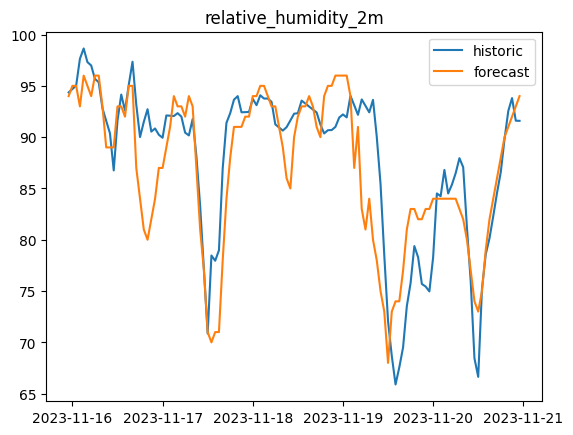

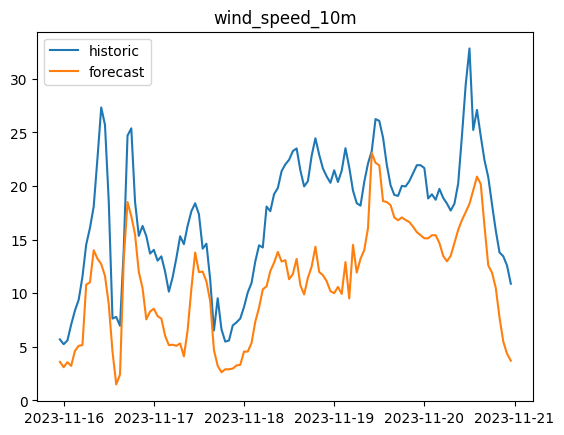

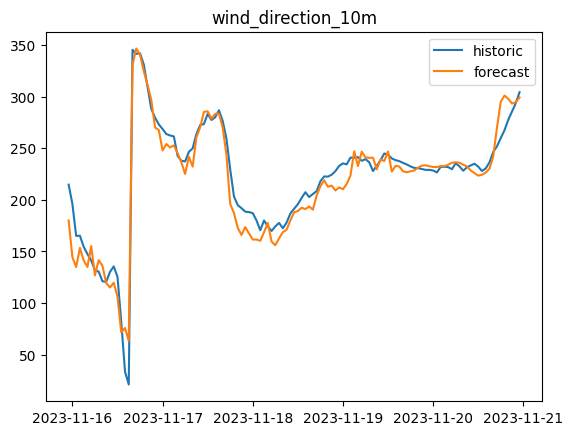

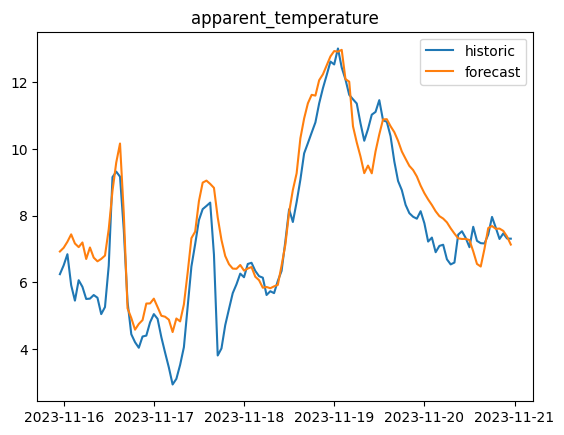

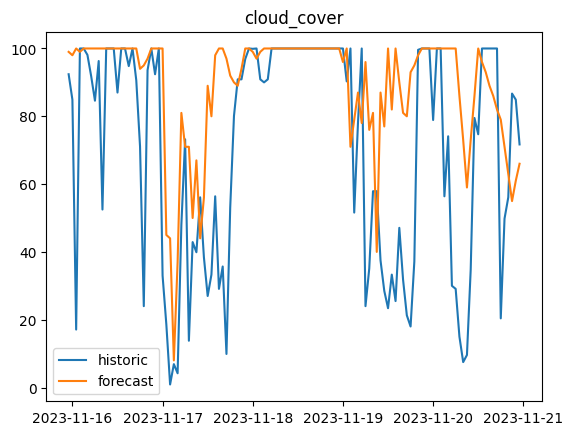

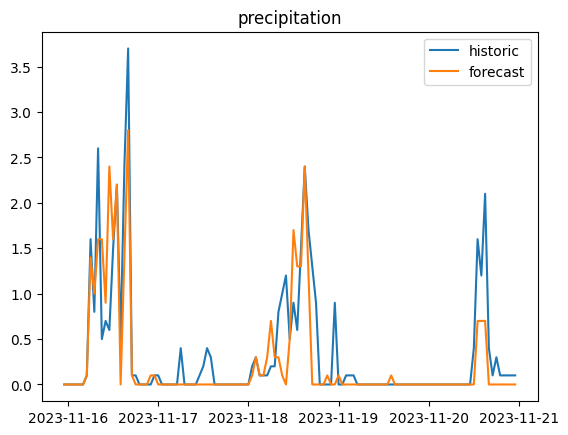

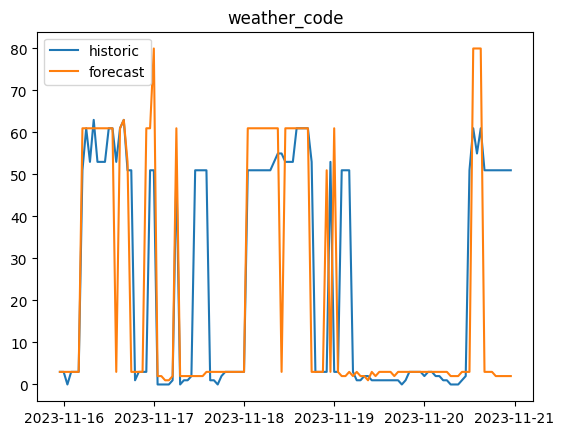

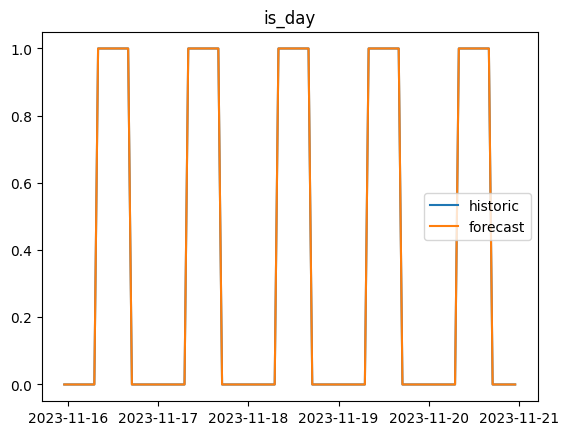

In [41]:
for feature in historic_df.columns[1:]:
    data = [
        historic_df[historic_df["date"].isin(forecast_df["date"])].sort_values("date")[["date", feature]],
        forecast_df[forecast_df["date"].isin(historic_df["date"])].sort_values("date")[["date", feature]]
    ]
    plt.figure()
    for df in data:
        x = df["date"]
        y = df[feature]
        plt.plot(x, y)
    plt.legend(["historic", "forecast"])
    plt.title(feature)
    plt.show()